Bed
Found 270 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
(256, 256, 3)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 127, 127, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 62, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 128)       73856     
                     

C:\Users\amins\AppData\Local\Temp\ipykernel_10548\1850568816.py:157: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(val_generator, steps=len(val_generator))


Test Loss: 0.46122652292251587
Test Accuracy: 0.8333333134651184


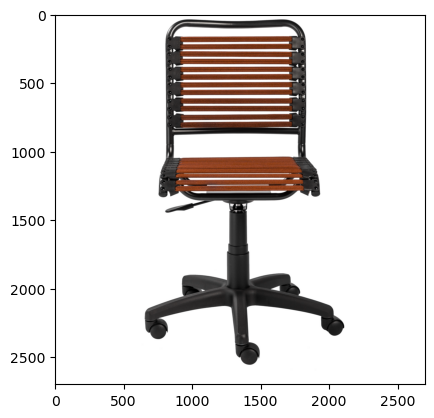

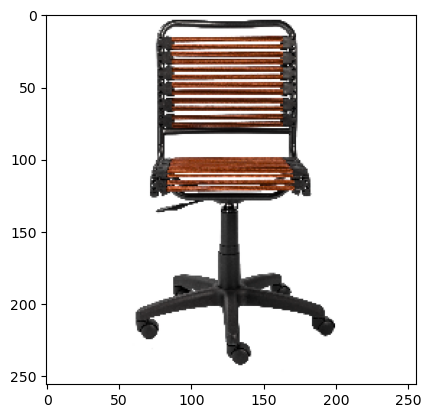

1/1 [==============================] - 0s 112ms/step
['Bed', 'Chair', 'Sofa'],Predicted class is Chair


In [20]:

# !pip install keras
# !pip install tensorflow
# !pip install opencv-python matplotlib
# !pip install nest-asyncio uvicorn
# !pip install python-multipart
# !pip install pyngrok
# !pip install -U uvicorn
# !pip install -U fastapi
# !pip install colabcode
#--------------------------------------------- Import Dependencies
import tensorflow as tf
import os
import cv2
import imghdr
%matplotlib inline               
import matplotlib.pyplot as plt
import numpy as np
import random
from colabcode import ColabCode
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# from tensorflow.keras.models import load_model
from pydantic import BaseModel

from fastapi import FastAPI , File, UploadFile
import uvicorn
import nest_asyncio
from pyngrok import ngrok
from uvicorn import Config, Server
from pydantic import BaseModel
import io
from PIL import Image

def avoid_error():
    """
    Avoid OOM errors by setting GPU Memory Consumption Growth
    """
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
        
    return()


def colab_unzip_file():
    """
    Unzip the dataset
    """
    from google.colab import drive
    drive.mount('/')
    !unzip Dataset.zip > /dev/null
    
    return()

def test_image(img_dir):
    """
    Test the data: get a direction of an image then see the image
    """
    img = cv2.imread(os.path.join(img_dir))
    plt.imshow(img)
    img.shape 
    
    return()


def data_set(data_dir, img_size, batch_size):
    """
    Reading Data & Spliting into Train/Test/Validation
    """
    # Define the data generator with preprocessing and augmentation options
    datagen = ImageDataGenerator(
        rescale=1./255, 
        shear_range=0.2, 
        zoom_range=0.2, 
        horizontal_flip=True,
        validation_split=0.1)

    # Load the images from the directory and split them into training and validation sets
    train_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training')

    val_generator = datagen.flow_from_directory(
        data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation')

    # Verify class indices
    print(train_generator.image_shape)
    
    return(train_generator, val_generator)



def classifier_model(input_shape):
    """
    Building Model - Simple CNN
    """
    model = Sequential([    
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(3, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    
    return(model)


def train_model(model, epoch_num, train_generator, val_generator):
    """
    Train the model and plot the loss values and accuracy
    """ 
    hist = model.fit(train_generator,
              epochs=epoch_num,
              validation_data=val_generator)
    # Plotting Loss & Accuracy
    fig = plt.figure()
    plt.plot(hist.history['loss'], color='teal', label='loss')
    plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
    fig.suptitle('Loss', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

    fig = plt.figure()
    plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
    fig.suptitle('Accuracy', fontsize=20)
    plt.legend(loc="upper left")
    plt.show()
    
    return(model)


def save_model(model):
    """
    Save the model
    """
    model.save(os.path.join('models','Imageclassifier.h5'))
    
    return()

def loading_model():
    """
    Load the model
    """
    model = load_model('models/Imageclassifier.h5')
    
    return(model)


def evaluate_model(model, val_generator):
    """
    Evaluating the model based on validation set
    """
    scores = model.evaluate_generator(val_generator, steps=len(val_generator))
    print("Test Loss:", scores[0])
    print("Test Accuracy:", scores[1])
    return()


#----------------------------------------------- Test the model
def test_model(model, path, img_size, label):
    """
    Test the model by putting the path of an image to see :
                - the class of the image
                - see the initial image and preprocessed image
    """
    img = cv2.imread(path)
    plt.imshow(img)
    plt.show()

    resize = tf.image.resize(img, img_size)
    plt.imshow(resize.numpy().astype(int))
    plt.show()

    yhat = model.predict(np.expand_dims(resize/255, 0))
    max_y = yhat[0].argmax()
    if max_y == 0: 
        print(f'{label}, Predicted class is {label[0]}')
    elif max_y==1:
        print(f'{label},Predicted class is {label[1]}')
    else:
        print(f'{label},Predicted class is {label[2]}')
    
    return()
    
    
#------------------------------------------------ API
cc = ColabCode(port=8000, code=False)
app = FastAPI()
db = []

@app.get('/')
async def read_root():
    return{"Message": "This is {name}"}

@app.post("/images/")
async def create_upload_file(file: UploadFile = File(...)):
    contents = await file.read() 
    db.append(file)
    with open(file.filename, "wb") as f:
        f.write(contents)
    return {"filename": file.filename}

@app.post("/Imagepredict")
async def Imagepredict_route(file: UploadFile = File(...)):
    img = await file.read()
    image1 = Image.open(io.BytesIO(img))
    resize = tf.image.resize(image1, (256,256))
    plt.imshow(resize.numpy().astype(int))
    plt.show()
    yhat = model.predict(np.expand_dims(resize/255, 0))
    label = yhat[0].argmax()
    if label == 0:
        result =f'Predicted class is {label[0]}'
    elif label == 1:
        result = f'Predicted class is {label[1]}'
    else:
        result = f'Predicted class is {label[2]}'
    print(result)
    return {"result": result}

if __name__ == '__main__':
    # Define the path to your data directory
    data_dir = 'ImageClasstificationDataset/Data for test' 
    
    path = 'ImageClasstificationDataset/Data for test/Chair/Allison Bungie Flat Low Back Office Chair.jpg'
    img_dir = 'ImageClasstificationDataset/Data for test/Bed/160 cm kingsize bed.jpg'
    label = ['Bed','Chair','Sofa']
    
    # Define the parameters for image preprocessing and augmentation
    img_size = (256,256)
    batch_size = 32
    input_shape = ( 256,256, 3)
    
    avoid_error()
#     colab_unzip_file()
    test_image(img_dir)
    train_set, val_set = data_set(data_dir, img_size, batch_size)
    model = classifier_model(input_shape)
    model = train_model(model, epoch_num, train_set, val_set)
    save_model(model)
    model = loading_model()
    evaluate_model(model, val_set)
    test_model(model, path, img_size, label)
#     uvicorn.run(app, host='0.0.0.0', port=8080)
    

In [21]:
!docker run -p 8888:8888 -v ~/notebooks:/home/jovyan jupyter/minimal-notebook

docker: error during connect: This error may indicate that the docker daemon is not running.: Post "http://%2F%2F.%2Fpipe%2Fdocker_engine/v1.24/containers/create": open //./pipe/docker_engine: The system cannot find the file specified.
See 'docker run --help'.


In [8]:
!wsl --update

I n s t a l l i n g :   W i n d o w s   S u b s y s t e m   f o r   L i n u x 
 
 
 W i n d o w s   S u b s y s t e m   f o r   L i n u x   h a s   b e e n   i n s t a l l e d . 
 
 
 
